# Part C – Programming Task (Python / Jupyter Notebook)
1. Implement A* search on a maze (given as a 2D matrix where 1=wall, 0=path, A=start,
B=goal).
- Use Manhattan distance as heuristic.
- Visualize the path found.

2. Modify the heuristic:
- Case 1: Multiply Manhattan distance by 1.5 (check if it is admissible).
- Case 2: Define heuristic so that for one edge it violates consistency.
3. For each case, run A* and record:
- Path found
- Cost of path
- Whether the path is optimal

In [25]:
import heapq
import copy
import numpy as np
import matplotlib.pyplot as plt

class MazeSolver:
    """
    A class to find a path through a maze using the A* search algorithm
    and provide visualizations of the solution and heuristics.
    """

    def __init__(self, maze):
        if not maze:
            raise ValueError("Input maze cannot be empty.")
        self.original_maze = copy.deepcopy(maze)
        self.processed_maze, self.start, self.goal = self._process_maze()
        if not self.start or not self.goal:
            raise ValueError("Maze must contain a start ('A') and a goal ('B').")

    def _process_maze(self):
        processed = []
        start_pos, goal_pos = None, None
        for r, row in enumerate(self.original_maze):
            new_row = []
            for c, cell in enumerate(row):
                if cell == 'A':
                    start_pos = (r, c)
                    new_row.append(0)
                elif cell == 'B':
                    goal_pos = (r, c)
                    new_row.append(0)
                else:
                    new_row.append(cell)
            processed.append(new_row)
        return processed, start_pos, goal_pos

    # --- Heuristic Definitions ---
    @staticmethod
    def manhattan_heuristic(a, b):
        return abs(a[0] - b[0]) + abs(a[1] - b[1])

    @staticmethod
    def weighted_manhattan_heuristic(a, b):
        return (abs(a[0] - b[0]) + abs(a[1] - b[1])) * 1.5

    def inconsistent_heuristic(self, a, b):
        if a == (2,1):
            return 1  # artificially low to break consistency
        return self.manhattan_heuristic(a, b)

    def _get_neighbors(self, pos):
        neighbors = []
        directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        rows, cols = len(self.processed_maze), len(self.processed_maze[0])
        for dr, dc in directions:
            nr, nc = pos[0] + dr, pos[1] + dc
            if 0 <= nr < rows and 0 <= nc < cols and self.processed_maze[nr][nc] != 1:
                neighbors.append((nr, nc))
        return neighbors

    def solve_with_a_star(self, heuristic_func):
        came_from = {}
        g_score = {self.start: 0}
        f_score = {self.start: heuristic_func(self.start, self.goal)}

        priority_queue = [(f_score[self.start], self.start)]

        while priority_queue:
            _, current = heapq.heappop(priority_queue)

            if current == self.goal:
                return self._reconstruct_path(came_from, current)

            for neighbor in self._get_neighbors(current):
                tentative_g_score = g_score.get(current, float('inf')) + 1

                if tentative_g_score < g_score.get(neighbor, float('inf')):
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g_score
                    f_score[neighbor] = tentative_g_score + heuristic_func(neighbor, self.goal)
                    heapq.heappush(priority_queue, (f_score[neighbor], neighbor))

        return []

    def _reconstruct_path(self, came_from, current):
        total_path = [current]
        while current in came_from:
            current = came_from[current]
            total_path.insert(0, current)
        return total_path

    def get_path_visualization(self, path):
        maze_copy = copy.deepcopy(self.original_maze)
        for r, c in path:
            if (r, c) != self.start and (r, c) != self.goal:
                maze_copy[r][c] = '*'
        return maze_copy

    def visualize_path_with_plot(self, path, title="A* Path Visualization"):
        maze_np = np.array(self.processed_maze, dtype=int)

        plt.figure(figsize=(8, 8))
        plt.imshow(maze_np, cmap="binary", interpolation='nearest')

        if path:
            y_coords, x_coords = zip(*path)
            plt.plot(x_coords, y_coords, marker="o", color="red", linewidth=2, label="Path")

        plt.scatter(self.start[1], self.start[0], color="green", s=200, label="A (Start)", zorder=5, edgecolors='black')
        plt.scatter(self.goal[1], self.goal[0], color="blue", s=200, label="B (Goal)", zorder=5, edgecolors='black')

        ax = plt.gca()
        ax.set_xticks(np.arange(0, maze_np.shape[1], 1))
        ax.set_yticks(np.arange(0, maze_np.shape[0], 1))
        ax.set_xticks(np.arange(-.5, maze_np.shape[1], 1), minor=True)
        ax.set_yticks(np.arange(-.5, maze_np.shape[0], 1), minor=True)
        ax.grid(which="minor", color="black", linestyle='-', linewidth=0.5)

        plt.legend()
        plt.title(title)
        plt.show()

    # --- Experiment Functions ---
    def run_experiment(self, heuristic_func, name="Heuristic"):
        path = self.solve_with_a_star(heuristic_func)
        cost = len(path) - 1 if path else float('inf')
        optimal_cost = len(self.solve_with_a_star(self.manhattan_heuristic)) - 1
        is_optimal = (cost == optimal_cost)

        print(f"--- {name} ---")
        print("Path:", path)
        print("Cost:", cost)
        print("Optimal:", is_optimal)
        print()
        return path, cost, is_optimal

    def check_admissibility(self, heuristic_func):
        """Check if heuristic ever overestimates the true shortest path cost."""
        from collections import deque

        def bfs_shortest(start, goal):
            q = deque([(start, 0)])
            visited = {start}
            while q:
                node, d = q.popleft()
                if node == goal:
                    return d
                for nb in self._get_neighbors(node):
                    if nb not in visited:
                        visited.add(nb)
                        q.append((nb, d + 1))
            return float('inf')

        for r in range(len(self.processed_maze)):
            for c in range(len(self.processed_maze[0])):
                if self.processed_maze[r][c] != 1:
                    true_cost = bfs_shortest((r, c), self.goal)
                    h_val = heuristic_func((r, c), self.goal)
                    if h_val > true_cost:
                        print(f"Not admissible: h({(r,c)})={h_val} > true cost {true_cost}")
                        return False
        print("Heuristic is admissible.")
        return True

--- Manhattan (Admissible & Consistent) ---
Path: [(2, 0), (2, 1), (2, 2), (2, 3), (2, 4)]
Cost: 4
Optimal: True



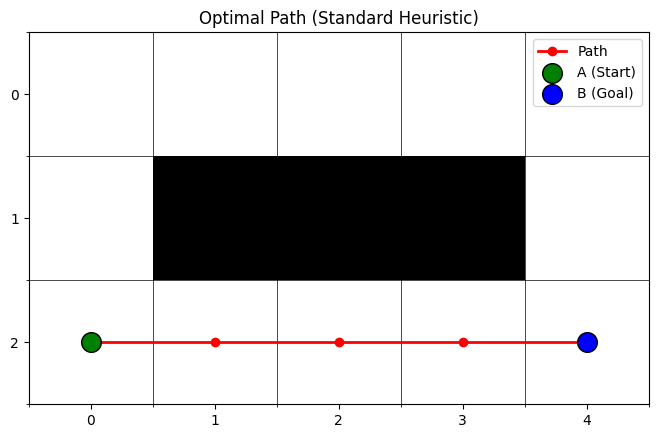

--- Weighted Manhattan (Inadmissible) ---
Path: [(2, 0), (2, 1), (2, 2), (2, 3), (2, 4)]
Cost: 4
Optimal: True



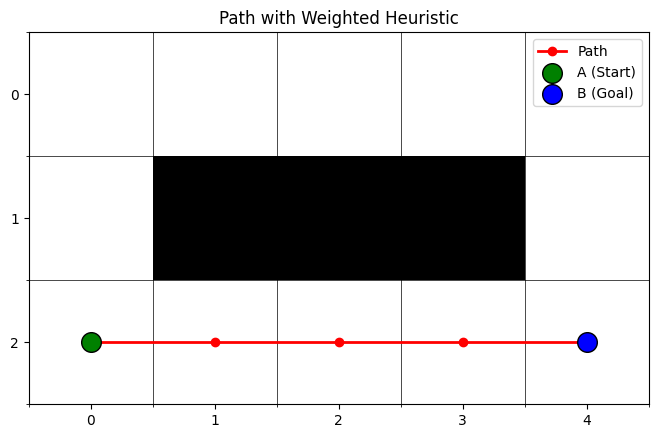

Not admissible: h((0, 0))=9.0 > true cost 6
--- Inconsistent Heuristic ---
Path: [(2, 0), (2, 1), (2, 2), (2, 3), (2, 4)]
Cost: 4
Optimal: True



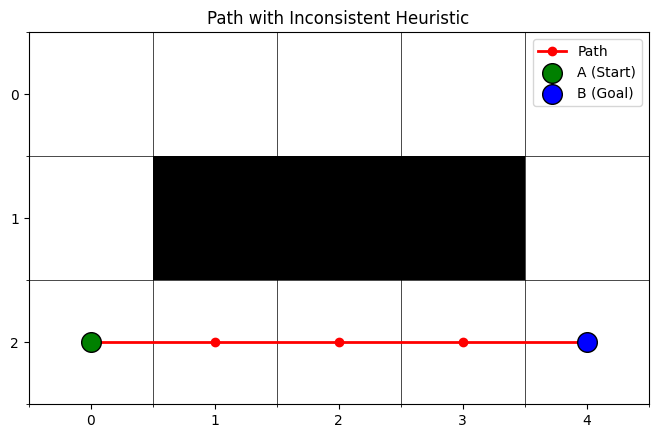

In [30]:
maze = [
    [0, 0, 0, 0, 0],
    [0, 1, 1, 1, 0],
    ['A', 0, 0, 0, 'B']
]
solver = MazeSolver(maze)

# --- Part 1: Standard Manhattan ---
print("="*60)
path_1, cost_1, opt_1 = solver.run_experiment(solver.manhattan_heuristic, "Manhattan (Admissible & Consistent)")
solver.visualize_path_with_plot(path_1, "Optimal Path (Standard Heuristic)")

# --- Part 2, Case 1: Weighted Manhattan ---
print("="*60)
path_2, cost_2, opt_2 = solver.run_experiment(solver.weighted_manhattan_heuristic, "Weighted Manhattan (Inadmissible)")
solver.visualize_path_with_plot(path_2, "Path with Weighted Heuristic")
solver.check_admissibility(solver.weighted_manhattan_heuristic)

# --- Part 2, Case 2: Inconsistent Heuristic ---
print("="*60)
path_3, cost_3, opt_3 = solver.run_experiment(solver.inconsistent_heuristic, "Inconsistent Heuristic")
solver.visualize_path_with_plot(path_3, "Path with Inconsistent Heuristic")



--- Manhattan (Admissible & Consistent) ---
Path: [(0, 0), (0, 1), (1, 1), (2, 1), (2, 2), (2, 3), (3, 3), (4, 3), (5, 3), (6, 3), (6, 4), (6, 5), (5, 5), (5, 6), (5, 7), (6, 7), (6, 8), (6, 9), (7, 9), (8, 9), (8, 10), (8, 11), (9, 11), (10, 11), (11, 11)]
Cost: 24
Optimal: True



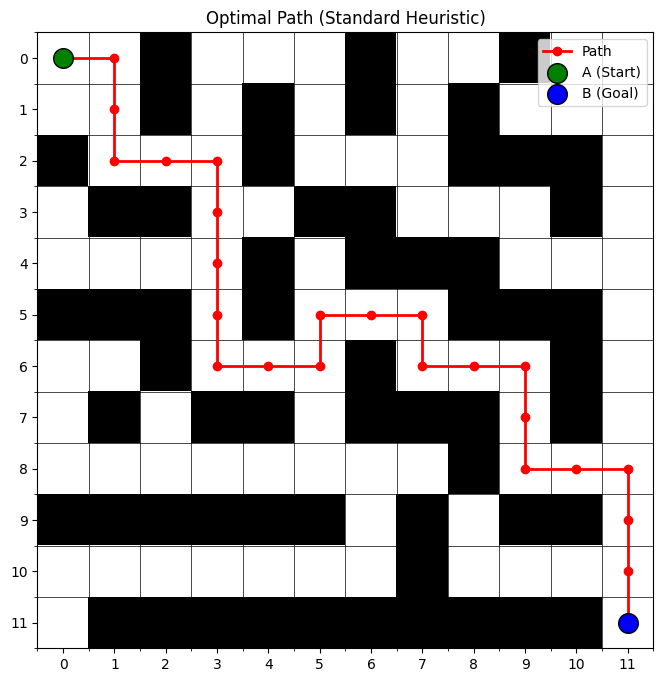

--- Weighted Manhattan (Inadmissible) ---
Path: [(0, 0), (0, 1), (1, 1), (2, 1), (2, 2), (2, 3), (3, 3), (4, 3), (5, 3), (6, 3), (6, 4), (6, 5), (5, 5), (5, 6), (5, 7), (6, 7), (6, 8), (6, 9), (7, 9), (8, 9), (8, 10), (8, 11), (9, 11), (10, 11), (11, 11)]
Cost: 24
Optimal: True



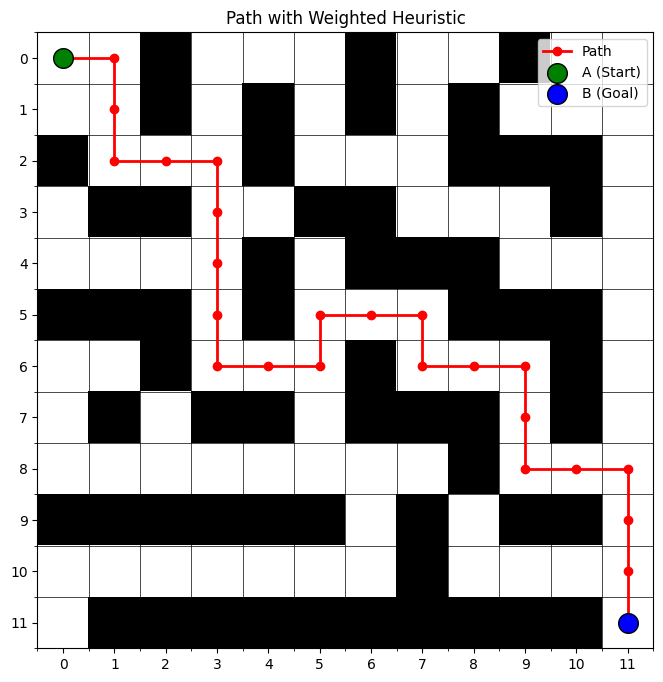

Not admissible: h((0, 0))=33.0 > true cost 24
--- Inconsistent Heuristic ---
Path: [(0, 0), (0, 1), (1, 1), (2, 1), (2, 2), (2, 3), (3, 3), (4, 3), (5, 3), (6, 3), (6, 4), (6, 5), (5, 5), (5, 6), (5, 7), (6, 7), (6, 8), (6, 9), (7, 9), (8, 9), (8, 10), (8, 11), (9, 11), (10, 11), (11, 11)]
Cost: 24
Optimal: True



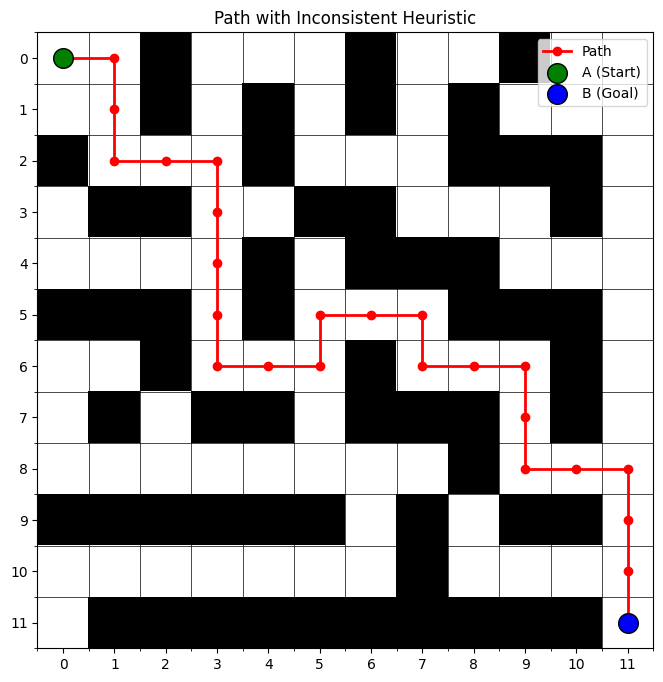

In [27]:
# Define the maze
maze5 = [
    ['A', 0,  1,  0,  0,  0, 1, 0, 0, 1, 0, 0],
    [0,   0,  1,  0,  1,  0, 1, 0, 1, 0, 0, 0],
    [1,   0,  0,  0,  1,  0, 0, 0, 1, 1, 1, 0],
    [0,   1,  1,  0,  0,  1, 1, 0, 0, 0, 1, 0],
    [0,   0,  0,  0,  1,  0, 1, 1, 1, 0, 0, 0],
    [1,   1,  1,  0,  1,  0, 0, 0, 1, 1, 1, 0],
    [0,   0,  1,  0,  0,  0, 1, 0, 0, 0, 1, 0],
    [0,   1,  0,  1,  1,  0, 1, 1, 1, 0, 1, 0],
    [0,   0,  0,  0,  0,  0, 0, 0, 1, 0, 0, 0],
    [1,   1,  1,  1,  1,  1, 0, 1, 0, 1, 1, 0],
    [0,   0,  0,  0,  0,  0, 0, 1, 0, 0, 0, 0],
    [0,   1,  1,  1,  1,  1, 1, 1, 1, 1, 1,'B'],
]

solver = MazeSolver(maze5)

# --- Part 1: Standard Manhattan ---
print("="*60)
path_1, cost_1, opt_1 = solver.run_experiment(solver.manhattan_heuristic, "Manhattan (Admissible & Consistent)")
solver.visualize_path_with_plot(path_1, "Optimal Path (Standard Heuristic)")

# --- Part 2, Case 1: Weighted Manhattan ---
print("="*60)
path_2, cost_2, opt_2 = solver.run_experiment(solver.weighted_manhattan_heuristic, "Weighted Manhattan (Inadmissible)")
solver.visualize_path_with_plot(path_2, "Path with Weighted Heuristic")
solver.check_admissibility(solver.weighted_manhattan_heuristic)

# --- Part 2, Case 2: Inconsistent Heuristic ---
print("="*60)
path_3, cost_3, opt_3 = solver.run_experiment(solver.inconsistent_heuristic, "Inconsistent Heuristic")
solver.visualize_path_with_plot(path_3, "Path with Inconsistent Heuristic")


--- Manhattan (Admissible & Consistent) ---
Path: [(0, 0), (0, 1), (1, 1), (2, 1), (2, 2), (2, 3), (3, 3), (4, 3), (5, 3), (6, 3), (6, 4), (6, 5), (5, 5), (5, 6), (5, 7), (6, 7), (6, 8), (6, 9), (7, 9), (8, 9), (9, 9)]
Cost: 20
Optimal: True



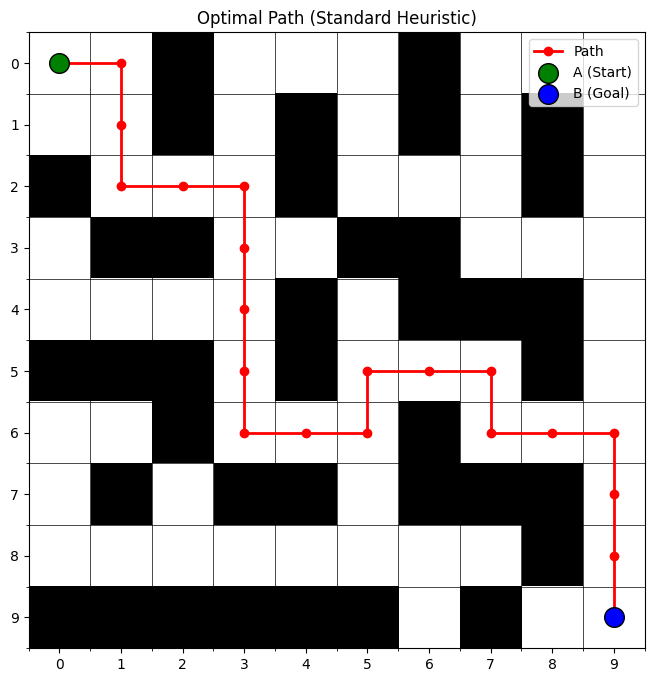

--- Weighted Manhattan (Inadmissible) ---
Path: [(0, 0), (0, 1), (1, 1), (2, 1), (2, 2), (2, 3), (3, 3), (4, 3), (5, 3), (6, 3), (6, 4), (6, 5), (5, 5), (5, 6), (5, 7), (6, 7), (6, 8), (6, 9), (7, 9), (8, 9), (9, 9)]
Cost: 20
Optimal: True



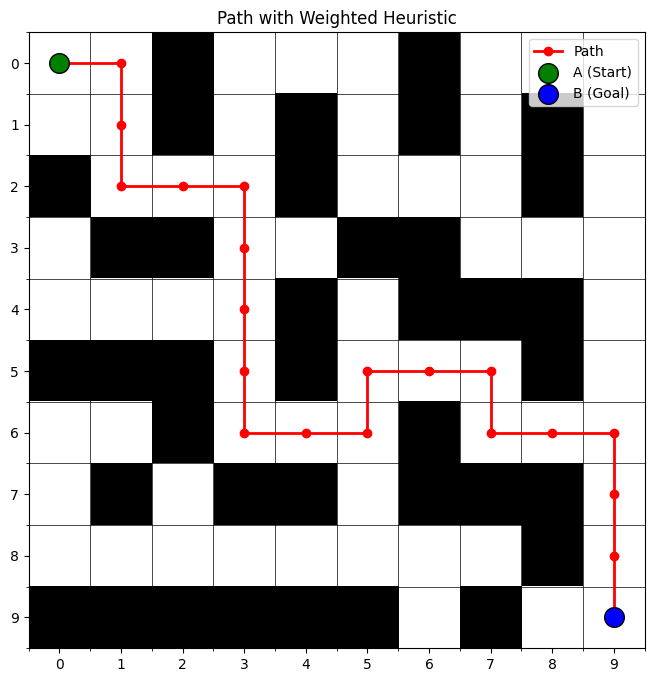

Not admissible: h((0, 0))=27.0 > true cost 20
--- Inconsistent Heuristic ---
Path: [(0, 0), (0, 1), (1, 1), (2, 1), (2, 2), (2, 3), (3, 3), (4, 3), (5, 3), (6, 3), (6, 4), (6, 5), (5, 5), (5, 6), (5, 7), (6, 7), (6, 8), (6, 9), (7, 9), (8, 9), (9, 9)]
Cost: 20
Optimal: True



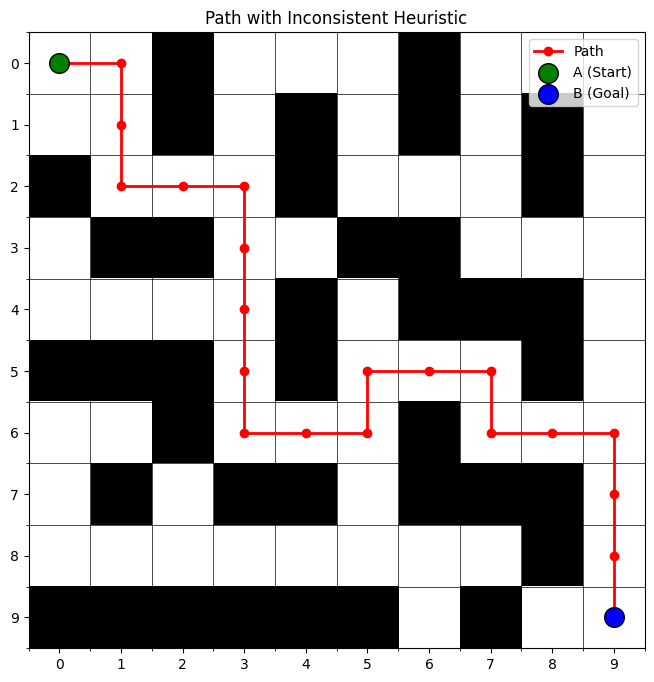

In [29]:
maze4 = [
    ['A', 0,  1,  0,  0,  0, 1, 0, 0, 0],
    [0,   0,  1,  0,  1,  0, 1, 0, 1, 0],
    [1,   0,  0,  0,  1,  0, 0, 0, 1, 0],
    [0,   1,  1,  0,  0,  1, 1, 0, 0, 0],
    [0,   0,  0,  0,  1,  0, 1, 1, 1, 0],
    [1,   1,  1,  0,  1,  0, 0, 0, 1, 0],
    [0,   0,  1,  0,  0,  0, 1, 0, 0, 0],
    [0,   1,  0,  1,  1,  0, 1, 1, 1, 0],
    [0,   0,  0,  0,  0,  0, 0, 0, 1, 0],
    [1,   1,  1,  1,  1,  1, 0, 1, 0,'B'],
]


solver = MazeSolver(maze4)

# --- Part 1: Standard Manhattan ---
print("="*60)
path_1, cost_1, opt_1 = solver.run_experiment(solver.manhattan_heuristic, "Manhattan (Admissible & Consistent)")
solver.visualize_path_with_plot(path_1, "Optimal Path (Standard Heuristic)")

# --- Part 2, Case 1: Weighted Manhattan ---
print("="*60)
path_2, cost_2, opt_2 = solver.run_experiment(solver.weighted_manhattan_heuristic, "Weighted Manhattan (Inadmissible)")
solver.visualize_path_with_plot(path_2, "Path with Weighted Heuristic")
solver.check_admissibility(solver.weighted_manhattan_heuristic)

# --- Part 2, Case 2: Inconsistent Heuristic ---
print("="*60)
path_3, cost_3, opt_3 = solver.run_experiment(solver.inconsistent_heuristic, "Inconsistent Heuristic")
solver.visualize_path_with_plot(path_3, "Path with Inconsistent Heuristic")



--- Manhattan (Admissible & Consistent) ---
Path: [(0, 0), (1, 0), (2, 0), (3, 0), (3, 1), (3, 2), (3, 3), (4, 3), (5, 3), (5, 4), (6, 4), (6, 5), (6, 6), (6, 7), (7, 7)]
Cost: 14
Optimal: True



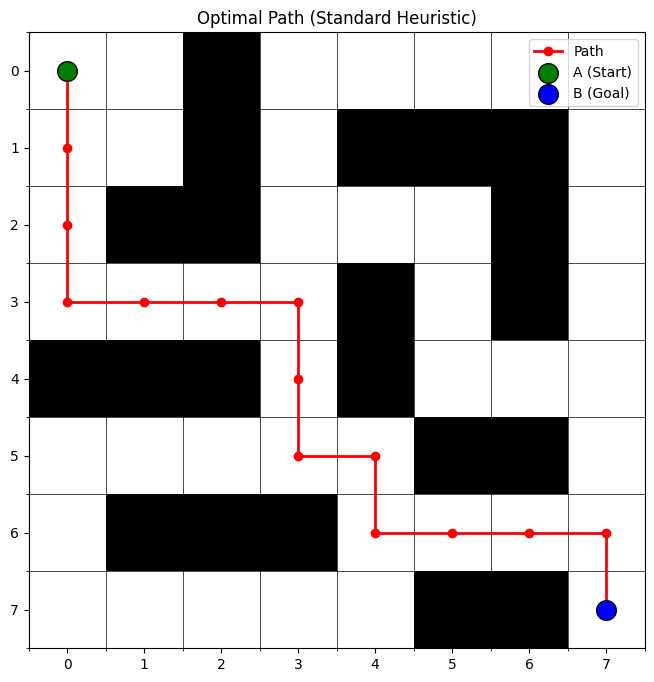

--- Weighted Manhattan (Inadmissible) ---
Path: [(0, 0), (1, 0), (2, 0), (3, 0), (3, 1), (3, 2), (3, 3), (4, 3), (5, 3), (5, 4), (6, 4), (6, 5), (6, 6), (6, 7), (7, 7)]
Cost: 14
Optimal: True



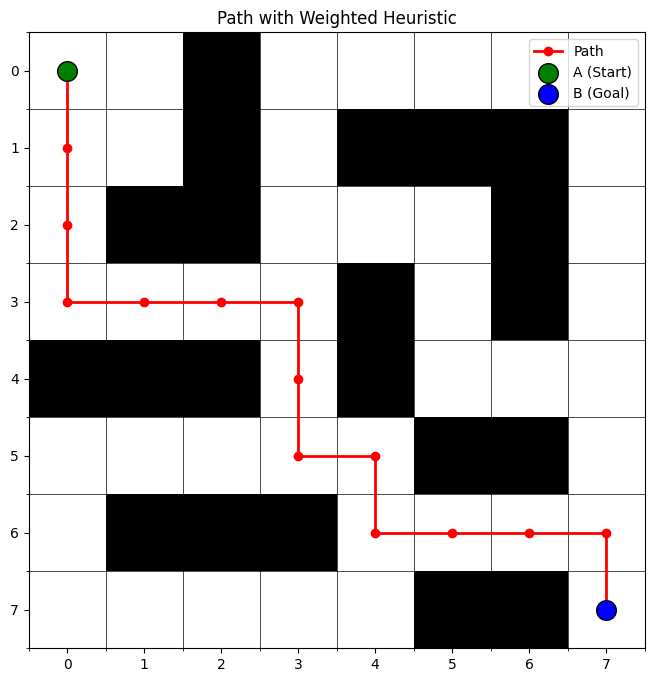

Not admissible: h((0, 0))=21.0 > true cost 14
--- Inconsistent Heuristic ---
Path: [(0, 0), (1, 0), (2, 0), (3, 0), (3, 1), (3, 2), (3, 3), (4, 3), (5, 3), (5, 4), (6, 4), (6, 5), (6, 6), (6, 7), (7, 7)]
Cost: 14
Optimal: True



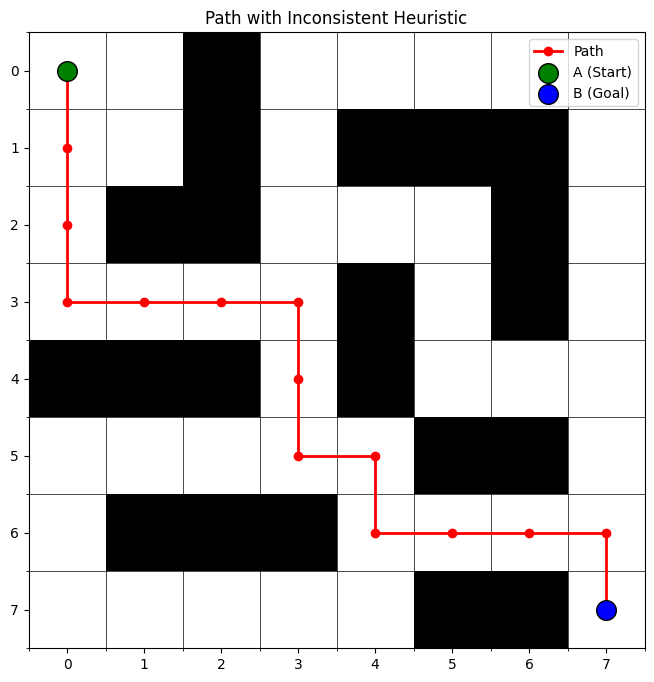

In [31]:
maze3 = [
    ['A', 0,  1,  0, 0, 0, 0, 0],
    [0,   0,  1,  0, 1, 1, 1, 0],
    [0,   1,  1,  0, 0, 0, 1, 0],
    [0,   0,  0,  0, 1, 0, 1, 0],
    [1,   1,  1,  0, 1, 0, 0, 0],
    [0,   0,  0,  0, 0, 1, 1, 0],
    [0,   1,  1,  1, 0, 0, 0, 0],
    [0,   0,  0,  0, 0, 1, 1,'B'],
]


solver = MazeSolver(maze3)
# --- Part 1: Standard Manhattan ---
print("="*60)
path_1, cost_1, opt_1 = solver.run_experiment(solver.manhattan_heuristic, "Manhattan (Admissible & Consistent)")
solver.visualize_path_with_plot(path_1, "Optimal Path (Standard Heuristic)")

# --- Part 2, Case 1: Weighted Manhattan ---
print("="*60)
path_2, cost_2, opt_2 = solver.run_experiment(solver.weighted_manhattan_heuristic, "Weighted Manhattan (Inadmissible)")
solver.visualize_path_with_plot(path_2, "Path with Weighted Heuristic")
solver.check_admissibility(solver.weighted_manhattan_heuristic)

# --- Part 2, Case 2: Inconsistent Heuristic ---
print("="*60)
path_3, cost_3, opt_3 = solver.run_experiment(solver.inconsistent_heuristic, "Inconsistent Heuristic")
solver.visualize_path_with_plot(path_3, "Path with Inconsistent Heuristic")




--- Manhattan (Admissible & Consistent) ---
Path: [(0, 0), (0, 1), (1, 1), (2, 1), (2, 0), (3, 0), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (5, 5)]
Cost: 12
Optimal: True



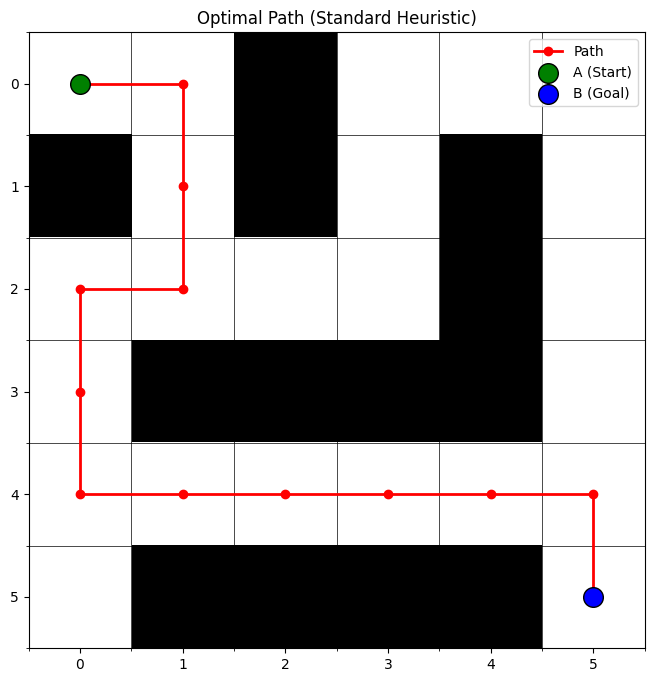

--- Weighted Manhattan (Inadmissible) ---
Path: [(0, 0), (0, 1), (1, 1), (2, 1), (2, 0), (3, 0), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (5, 5)]
Cost: 12
Optimal: True



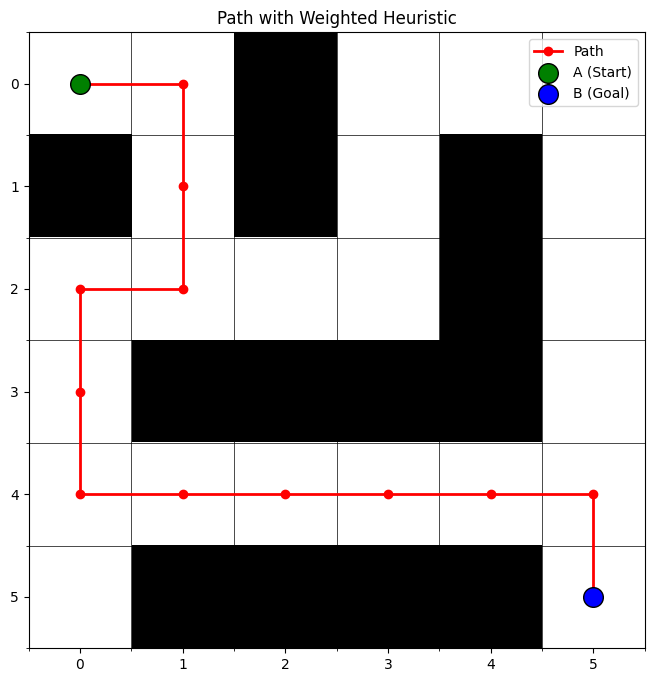

Not admissible: h((0, 0))=15.0 > true cost 12
--- Inconsistent Heuristic ---
Path: [(0, 0), (0, 1), (1, 1), (2, 1), (2, 0), (3, 0), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (5, 5)]
Cost: 12
Optimal: True



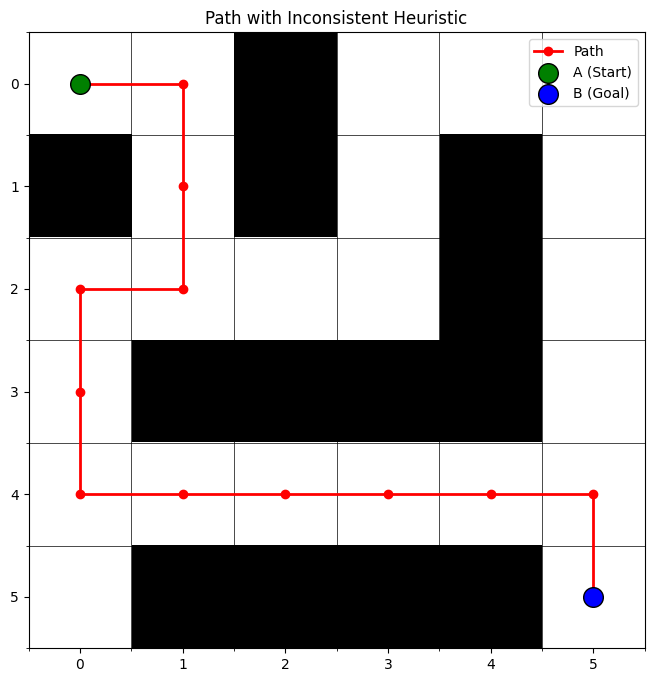

In [32]:
maze2 = [
    ['A', 0,   1,  0, 0, 0],
    [1,   0,   1,  0, 1, 0],
    [0,   0,   0,  0, 1, 0],
    [0,   1,   1,  1, 1, 0],
    [0,   0,   0,  0, 0, 0],
    [0,   1,   1,  1, 1,'B'],
]


solver = MazeSolver(maze2)

# --- Part 1: Standard Manhattan ---
print("="*60)
path_1, cost_1, opt_1 = solver.run_experiment(solver.manhattan_heuristic, "Manhattan (Admissible & Consistent)")
solver.visualize_path_with_plot(path_1, "Optimal Path (Standard Heuristic)")

# --- Part 2, Case 1: Weighted Manhattan ---
print("="*60)
path_2, cost_2, opt_2 = solver.run_experiment(solver.weighted_manhattan_heuristic, "Weighted Manhattan (Inadmissible)")
solver.visualize_path_with_plot(path_2, "Path with Weighted Heuristic")
solver.check_admissibility(solver.weighted_manhattan_heuristic)

# --- Part 2, Case 2: Inconsistent Heuristic ---
print("="*60)
path_3, cost_3, opt_3 = solver.run_experiment(solver.inconsistent_heuristic, "Inconsistent Heuristic")
solver.visualize_path_with_plot(path_3, "Path with Inconsistent Heuristic")



--- Manhattan (Admissible & Consistent) ---
Path: [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4)]
Cost: 4
Optimal: True



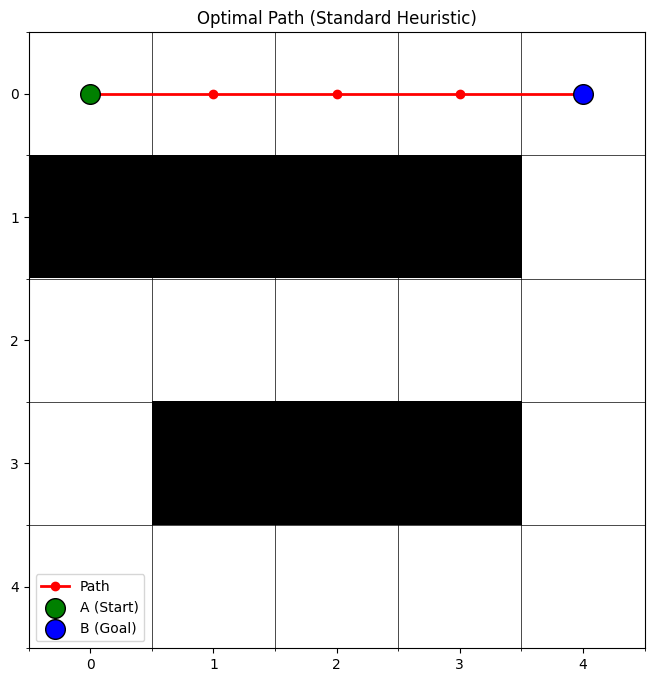

--- Weighted Manhattan (Inadmissible) ---
Path: [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4)]
Cost: 4
Optimal: True



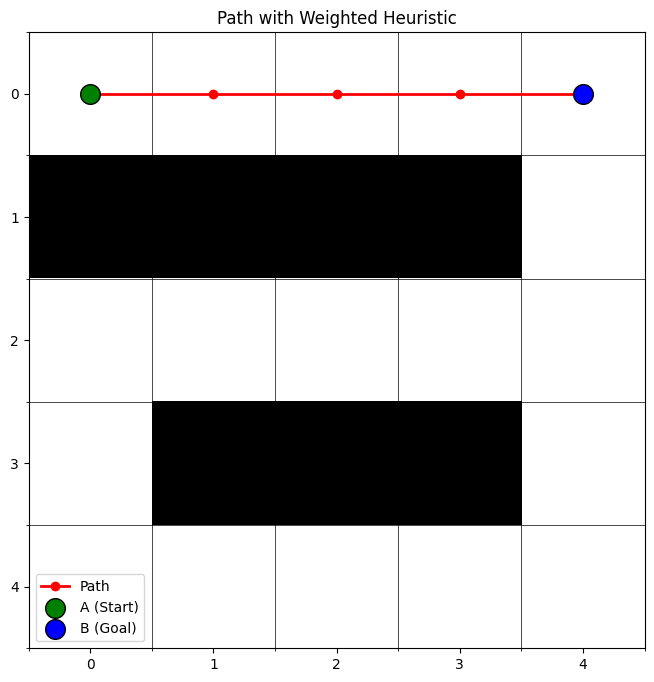

Not admissible: h((0, 0))=6.0 > true cost 4
--- Inconsistent Heuristic ---
Path: [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4)]
Cost: 4
Optimal: True



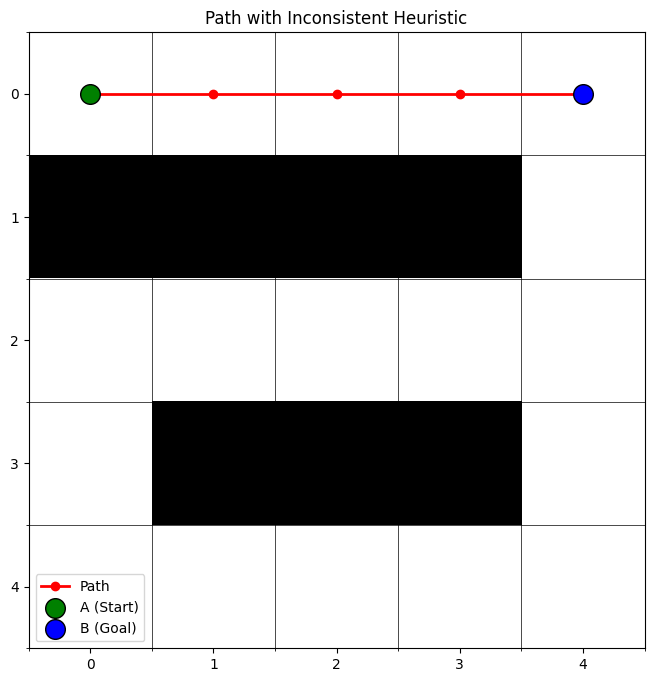

In [33]:
maze1 = [
    ['A', 0, 0, 0, 'B'],
    [1,   1, 1, 1,  0],
    [0,   0, 0, 0,  0],
    [0,   1, 1, 1,  0],
    [0,   0, 0, 0,  0],
]

solver = MazeSolver(maze1)

# --- Part 1: Standard Manhattan ---
print("="*60)
path_1, cost_1, opt_1 = solver.run_experiment(solver.manhattan_heuristic, "Manhattan (Admissible & Consistent)")
solver.visualize_path_with_plot(path_1, "Optimal Path (Standard Heuristic)")

# --- Part 2, Case 1: Weighted Manhattan ---
print("="*60)
path_2, cost_2, opt_2 = solver.run_experiment(solver.weighted_manhattan_heuristic, "Weighted Manhattan (Inadmissible)")
solver.visualize_path_with_plot(path_2, "Path with Weighted Heuristic")
solver.check_admissibility(solver.weighted_manhattan_heuristic)

# --- Part 2, Case 2: Inconsistent Heuristic ---
print("="*60)
path_3, cost_3, opt_3 = solver.run_experiment(solver.inconsistent_heuristic, "Inconsistent Heuristic")
solver.visualize_path_with_plot(path_3, "Path with Inconsistent Heuristic")


